## Introduction
We start by submitting our dataset to the S3 bucket. The entire data is loaded onto the cloud using the Data Migration Service(DMS) as shown in the following image. The DMS transfers entire data into the S3 bucket. Further an EC2 instance allow us the ease of processing within the AWS. The entire load process took (~1min) and can be handled by data scientists, data analysts as well as data engineers.

In [5]:
import timeit ## We will also measure time for the entire process
start = timeit.default_timer()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

> Data stored in the local machines/cloud

> Stored data is then loaded into S3 buckets from the local machine using DMS

> The data in S3 can be directly used for processing via Sagemaker using Pyspark (To allow parallel processing)

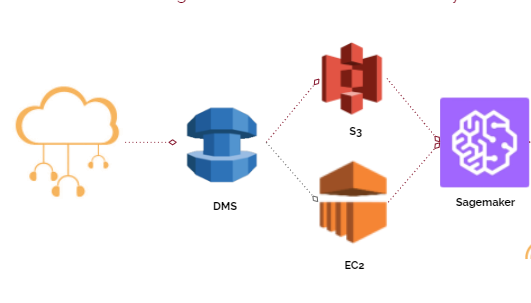

## Read the file

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1651335668861_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# read in the file
rate = spark.read.format("csv").option("header", False).option("delimiter", "\t").option("inferSchema",True).load("s3://music-recommender-system/ydata-ymusic-user-artist-ratings-v1_0.txt")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
type(rate)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

In [4]:
# Rename the dataframe
ratings = rate.withColumnRenamed("_c0","user_id")\
            .withColumnRenamed("_c1","artist_id")\
            .withColumnRenamed("_c2","rating")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
type(ratings)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

## Exploratory Data Analysis

### Overview of the dataset

In [6]:
ratings_10 = ratings.sample(0.0001,seed=123)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
ratings_10.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

11769

In [10]:
# data size
ratings_cnt = ratings_10.select("rating").count()
user_cnt = ratings_10.select("user_id").distinct().count()
artist_cnt = ratings_10.select("artist_id").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
print("The rating data includes", ratings_cnt, "rating scores for",
      artist_cnt,"artists from",user_cnt,"users.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The rating data includes 11769 rating scores for 3003 artists from 11511 users.

### Utility Matrix Sparsity

In real world problems, the utility matrix is expected to be very sparse, as each user only encounters a small fraction of items among the vast pool of options available. we calculate matrix sparsity with the formula of dividing ACTUAL rating number divided by IDEAL rating number (the number assuming EACH user give rating for EACH artist). Our utility matrix is 99.94% sparse, meaning 99.94% of the possible of user&artist rating is uncovered in the data.

In [12]:
def get_mat_sparsity(ratings_10):
    # Count the number of distinct userIds and distinct movieIds
    total_elements = user_cnt * artist_cnt

    # Divide the numerator by the denominator
    sparsity = (1.0 - (ratings_cnt *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% sparse.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
print("*** Matrix Sparsity ***")
get_mat_sparsity(ratings_10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

*** Matrix Sparsity ***
The ratings dataframe is  99.97% sparse.

## Recommender System Building

In [14]:
# Create test and train set
(train, test) = ratings_10.randomSplit([0.8, 0.2], seed = 2020)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ALS model
als = ALS(
         userCol = "user_id", 
         itemCol = "artist_id",
         ratingCol = "rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Import the requisite packages
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num models to be tested:  16

In [19]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
#Fit cross validator to the 'train' dataset
model = cv.fit(train)
#Extract best model from the cv model above
best_model = model.bestModel

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
print("**Best Model**")
# Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())
# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Best Model**
  Rank: 150
  MaxIter: 10
  RegParam: 0.05

In [22]:
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

40.54461029115044

## Provide Recommendation for Each User

In [25]:
# Generate n Recommendations for all users
recommendations = best_model.recommendForAllUsers(5)
recommendations.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|  10311|[[1006020, 62.484...|
|  16339|[[1023607, 103.36...|
|  19066|[[1000090, 0.0], ...|
|  22068|[[1098129, 102.71...|
|  28049|[[1029425, 97.408...|
|  35311|[[1029425, 110.20...|
|  42132|[[1100715, 107.36...|
|  45688|[[1017031, 69.999...|
|  51483|[[1023607, 99.210...|
|  53526|[[1000090, 0.0], ...|
|  53603|[[1100715, 121.38...|
|  54282|[[1015829, 114.07...|
|  57050|[[1006020, 95.360...|
|  62773|[[1000090, 0.0], ...|
|  62953|[[1098129, 56.031...|
|  67169|[[1015829, 44.336...|
|  69562|[[1000090, 0.0], ...|
|  75265|[[1015387, 102.80...|
|  81721|[[1015387, 118.47...|
|  83224|[[1006020, 104.79...|
+-------+--------------------+
only showing top 20 rows

In [63]:
from pyspark.sql.functions import col
nrecommendations = recommendations\
    .withColumn("rec_exp", pyspark.sql.functions.explode("recommendations"))\
    .select('user_id', col("rec_exp.artist_id"), col("rec_exp.rating"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
type(recommendations)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

In [ ]:
import pyspark.sql
nrecommendations = recommendations.withColumn("rec_exp",pyspark.sql.functions.explode(col="recommendations"))

#### How does recommendations look like?

In [65]:
recommendations.show(10,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                              |
+-------+-------------------------------------------------------------------------------------------------------------+
|10311  |[[1006020, 62.48427], [1011114, 53.243324], [1015387, 45.35247], [1029425, 43.57471], [1098129, 42.2953]]    |
|16339  |[[1023607, 103.365456], [1100715, 99.536026], [1021912, 89.99909], [1029425, 79.826416], [1098363, 73.12858]]|
|19066  |[[1000090, 0.0], [1000370, 0.0], [1000490, 0.0], [1000680, 0.0], [1000820, 0.0]]                             |
|22068  |[[1098129, 102.7107], [1017880, 89.99931], [1015387, 79.8805], [1006020, 79.48323], [1029425, 75.59533]]     |
|28049  |[[1029425, 97.40822], [1098129, 90.5287], [1013012, 89.999016], [1015387, 87.94255], [1011114, 87.29858]]    |
|35311  |[[1029425, 110.20514], [1015829

In [64]:
nrecommendations.limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+----------+
|user_id|artist_id|    rating|
+-------+---------+----------+
|  10311|  1006020|  62.48427|
|  10311|  1011114| 53.243324|
|  10311|  1015387|  45.35247|
|  10311|  1029425|  43.57471|
|  10311|  1098129|   42.2953|
|  16339|  1023607|103.365456|
|  16339|  1100715| 99.536026|
|  16339|  1021912|  89.99909|
|  16339|  1029425| 79.826416|
|  16339|  1098363|  73.12858|
+-------+---------+----------+

### Save the file (Recommendations)
1. S3 Bucket -> Quicksight
2. Dynamo DB (Which serves to customers)
3. Saved it to RDS -> Quicksight

#### S3

In [24]:
nrecommendations.repartition(1).write.format("com.databricks.spark.csv").option("header", "true").\
            save("s3://music-recommender-system/recommendation1.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

###### Dynamo DB

In [31]:
# <-- DataFrame of Row objects with inferred schema.
dynamoDf = spark.read.option("tableName", "recommendations").\
                format("dynamodb").\
                load("s3://music-recommender-system/recommendation1.csv") 


# write to some other table overwriting existing item with same keys
dynamoDf.write.option("tableName", "recommendations1") \
              .format("dynamodb") \
              .save()

An error was encountered:
Invalid status code '404' from http://172.31.32.5:8998/sessions/1 with error payload: {"msg":"Session '1' not found."}


##### RDS

In [ ]:
nrecommendations.repartition(1).write.format('jdbc').options(
      url='recommendation.cluster-cn7onn7xnjzb.us-east-1.rds.amazonaws.com',
      driver='com.mysql.jdbc.Driver',
      dbtable='recommendation',
      user='admin',
      password='minneosta2022').mode('overwrite').save()

In [8]:
stop = timeit.default_timer()
print(stop-start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

69.06563389800067

<font color="red"> **Business Analysts/Business Managers:** <font color="black"> We then use the RDS/S3 buckets to load the data into the Amazon Quicksight
    
<font color="red"> **Recommendations Delivery to Customers:** <font color="black"> Use the created Dynamo DB to serve the recommendations as key-value pair to customers

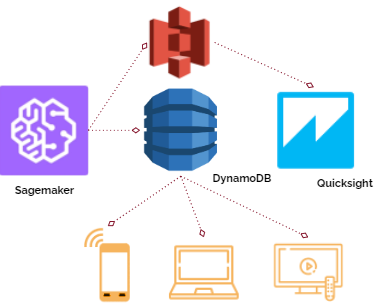

#### How Dynamo DB can help serve recommendations to users?

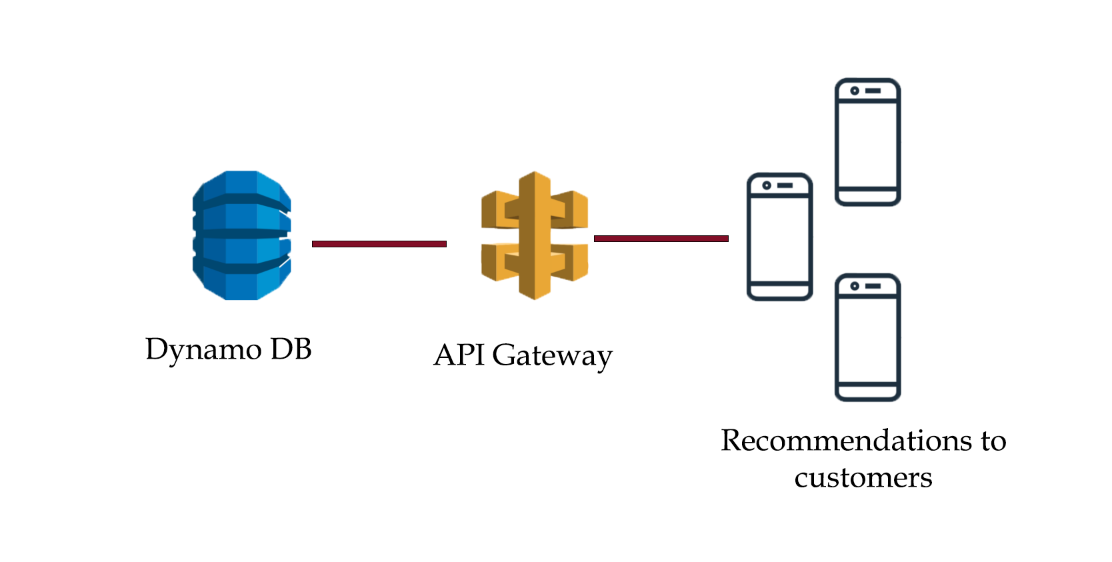

---